In [20]:
#-------------------------------------------------------
def Lagrange_polynomial(x, i, points):
    ''' Compute lagrangian interpolation polynomial 
    over domain x at specific points '''
    p = 1
    for k in range(len(points)):
        if k != i:
            p *= (x - points[k]) / (points[i] - points[k])
    return p

#-------------------------------------------------------
def Lagrange_polynomial_basis(x, points, N):
    ''' Compute complete basis of lagrange polynomials 
    at specified points '''
    return [Lagrange_polynomial(x, i, points) for i in range(N+1)]

#-------------------------------------------------------
def Chebyshev_nodes(a, b, N):
    ''' Computes Chebyshev nodes in a specific range'''
    from math import cos, pi
    return [0.5*(a+b) + 0.5*(b-a)*cos((2.*i+1.)/(2.*(N+1.))*pi) for i in range(N+1)]

#-------------------------------------------------------
def Uniform_nodes(a, b, N):
    '''Computes uniformly spaced nodes'''
    h = (b-a) / N
    return [a + i*h for i in range(N+1)]

#-------------------------------------------------------
def init_elements(Omega, N, n, **kwargs):
    ''' Function initializes a 2D array which defines N+1 global 
        1D finite elements, with n+1 nodes inside each element
        in the domain Omega = (x0, x1) '''
    node_spacing = kwargs.get('node_spacing', 'uniform')
    if (node_spacing == 'uniform'):
        nodes = Uniform_nodes(Omega[0], Omega[1], n + N*n)
    elif (node_spacing == 'chebyshev'):
        nodes = Chebyshev_nodes(Omega[0], Omega[1], n + N*n)
    # Initialize elements
    elements = [[i-j%(N+1) for i in range(j*(n+1), (j+1)*(n+1))] for j in range(N+1)]
    return (nodes, elements)

# Finite Element Method in 1D using Least Squares Method

##  Element matrix 

### Indice notation
- $e$: Element indice
- $r$: local node indice
- $i$: global node indice
- $i = q(e,r)$: Mapping of local node number $r$ in element $e$ to the global node number $i$. Mathematical notation for $i = elements[e][r]$

### Element matrix definition
$(d+1)\times(d+1)$-Matrix, that stores the local contributions 
$$
A_{i,j}^{(e)} 
= \int_{\Omega^{(e)}} \phi_i \phi_j \text{d}x 
= \int_{\Omega^{(e)}} \phi_{q(e,r)} \phi_{q(e,s)} \text{d}x
$$

Let $I_d = \{0,...,d\}$ be the valid indices of $r$ and $s$. We then introduce the notation
$$
\tilde{A}^{(e)} = \left\{\tilde{A}^{(e)}_{r,s}\right\}, \qquad r,s \in I_d
$$
For example, $d=2$ leads to
$$
\tilde{A}^{(e)} = 
\begin{bmatrix}
\tilde{A}^{(e)}_{0,0} & \tilde{A}^{(e)}_{0,1} & \tilde{A}^{(e)}_{0,2} \\
\tilde{A}^{(e)}_{1,0} & \tilde{A}^{(e)}_{1,1} & \tilde{A}^{(e)}_{1,2} \\
\tilde{A}^{(e)}_{2,0} & \tilde{A}^{(e)}_{2,1} & \tilde{A}^{(e)}_{2,2} \\
\end{bmatrix}
$$

### Affine mapping
Instead of computing the integrals in $\tilde{A}^{(e)}$ for every element domain $\Omega^{(e)} = [x_L, x_R]$, a reference element is introduced over the domain $[-1,1]$. 

A linear affine mapping from $X \in [-1,1]$ to $x \in \Omega^{(e)}$ leads to
$$
x 
= \frac{1}{2} (x_L + x_R) + \frac{1}{2} (x_R - x_L) X 
= x_m + \frac{1}{2} h X 
$$

The integration over the reference element is a matter of changing the integration variable from $x$ to $X$. 
Introducing the basis function 
$$
\tilde{\phi}_r(X) =  \phi_{q(e,r)}\left(x(X)\right)
$$
associated with the local node $r$ in the reference element.
The element matrix entry for the reference element reads then
$$
\tilde{A}^{(e)}_{r,s} 
= \int_{\Omega^{(e)}} \phi_{q(e,r)} \phi_{q(e,s)} \text{d}x
= \int_{-1}^{1} \tilde{\phi}_r(X) \tilde{\phi}_s(X) \frac{\text{d}x}{\text{d}X} \text{d}X
= \int_{-1}^{1} \tilde{\phi}_r(X) \tilde{\phi}_s(X) \text{det}(J)  \text{d}X
$$
Hereby the factor $\frac{\text{d}x}{\text{d}X}$ is the determinant of the Jacobian matrix of the mapping between the coordinate systemxs. For 1D problems, this factor reduces to $\text{det}(J) = h/2$.
The corresponding entries for the element right hand side of the linear equation system reads
$$
\tilde{b}_{r}^{(e)} 
= \int_{\Omega^{(e)}} f(x) \phi_{q(e,r)}(x) \text{d}x
= \int_{-1}^1 f\left(x(X)\right) \tilde{\phi}_r(X) \text{det}(J)  \text{d}X
$$

The $\tilde{\phi}_r(X)$ fuctions are the Lagrangian polynomials defined through the local nodes of the reference element.




In [2]:
# https://github.com/hplgit/INF5620/blob/master/src/fem/fe_approx1D.py
import numpy as np
from scipy import integrate

#=======================================================
# Implementation of the Finite Element Method in 1D
# for the approximateion of a function f(x)
#=======================================================

#-------------------------------------------------------
def Lagrange_polynomial(x, i, points):
    ''' Compute lagrangian interpolation polynomial 
    over domain x at specific points '''
    p = 1
    for k in range(len(points)):
        if k != i:
            p *= (x - points[k]) / (points[i] - points[k])
    return p

#-------------------------------------------------------
def phi_r(r, X, d):
    ''' Defines a Lagrangian basis function for the  
    local node r of an reference element of 
    degree d '''
    nodes = np.linspace(-1., 1., d+1)
    return Lagrange_polynomial(X, r, nodes)

#-------------------------------------------------------
def basis(X, d=1):
    ''' Create all basis functions for a reference 
    element of degree d
    '''
    phi = [phi_r(r, X, d) for r in range(d+1)]
    return phi

#-------------------------------------------------------
def element_matrix(X, phi, Omega_e):
    ''' Creates the element matrix for an element over
    its local domain Omega_e=[x0_e, x1_e] and its 
    basis functions stored in phi 
    '''
    n = len(phi)
    A_e = np.zeros((n,n))
    h = Omega_e[1] - Omega_e[0]
    detJ = 0.5*h
    for r in range(n):
        for s in range(n):
            A_e[r, s] = np.trapz(phi[r]*phi[s]*detJ, X)
            A_e[s, r] = A_e[r, s]
    return A_e

#-------------------------------------------------------
def element_rhs(X, f, phi, Omega_e):
    n = len(phi)
    b_e = np.zeros(n)
    h = Omega_e[1] - Omega_e[0]
    detJ = 0.5*h
    # Compute mapping from f(x) to f(x(X))
    x = np.linspace(Omega_e[0], Omega_e[1], len(X))
    f_map = f(x)
    for r in range(n):
        b_e[r] = np.trapz(f_map*phi[r]*detJ, X)
    return b_e



# Test the fem-functions
#-------------------------------------------------------
d = 1
Omega_e = (0, 1)
X = np.linspace(-1, 1, 501)
f = lambda x: x*(1-x)

# Analytical solutions 
#-------------------------------------------------------
print("\nAnalytical soltion to element matrix and element rhs (only for d=1): ")
h = Omega_e[1] - Omega_e[0]
xm = 0.5 * (Omega_e[1] + Omega_e[0])
print("h: " + str(h))
print("A[i][i]: " + str(h/3))
print("A[i][j]: " + str(h/6))
print("b[0]: " + str(-(1./24.) * h**3 + (xm/6.)*h**2 - (1./12.)*h**2 - 0.5*xm**2*h + 0.5*h*xm))
print("b[1]: " + str(-(1./24.) * h**3 - (xm/6.)*h**2 + (1./12.)*h**2 - 0.5*xm**2*h + 0.5*h*xm))
#-------------------------------------------------------

# Numerical solution
#-------------------------------------------------------
print("\nNumerical soltion to element matrix and element rhs: ")
phi = basis(X, d)
A_e = element_matrix(X, phi, Omega_e)
b_e = element_rhs(X, f, phi, Omega_e)

print(A_e)
print(b_e)


Analytical soltion to element matrix and element rhs (only for d=1): 
h: 1
A[i][i]: 0.3333333333333333
A[i][j]: 0.16666666666666666
b[0]: 0.08333333333333334
b[1]: 0.08333333333333331

Numerical soltion to element matrix and element rhs: 
[[0.333334 0.166666]
 [0.166666 0.333334]]
[0.083333 0.083333]


## Global matrix / Finite Element Assembly Matrix
The global matrix entries $A_{i,j}$ are the sum of the local element matrix entries 
$$
A_{i,j} = \int_{\Omega} \phi_i \phi_j \text{d}x = \sum_{e=0}^{N} A_{i,j}^{(e)}
$$


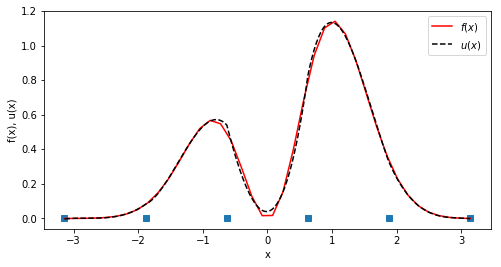

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

#-------------------------------------------------------
def Uniform_nodes(a, b, N):
    '''Computes uniformly spaced nodes'''
    h = (b-a) / N
    return [a + i*h for i in range(N+1)]

#-------------------------------------------------------
def init_mesh(Omega, N, n, **kwargs):
    ''' Function initializes a 2D array which defines N+1 global 
        1D finite elements, with n+1 nodes inside each element
        in the domain Omega = (x0, x1) '''
    node_spacing = kwargs.get('node_spacing', 'uniform')
    if (node_spacing == 'uniform'):
        nodes = Uniform_nodes(Omega[0], Omega[1], n + N*n)
    elif (node_spacing == 'chebyshev'):
        nodes = Chebyshev_nodes(Omega[0], Omega[1], n + N*n)
    # Initialize elements
    elements = [[i-j%(N+1) for i in range(j*(n+1), (j+1)*(n+1))] for j in range(N+1)]
    return (nodes, elements)


#-------------------------------------------------------
def assemble(nodes, elements, X, phi, f):
    ''' Function to assemble the global linear system of 
    equations A*x=b for a given mesh which is defined 
    through nodes and elements
    '''
    N_n, N_e = len(nodes), len(elements)
    A = np.zeros((N_n, N_n))
    b = np.zeros(N_n)
    
    for e in range(N_e):
        Omega_e = (nodes[elements[e][0]], nodes[elements[e][-1]])
        A_e = element_matrix(X, phi, Omega_e)
        b_e = element_rhs(X, f, phi, Omega_e)
        
        for r in range(len(elements[e])):
            for s in range(len(elements[e])):
                A[elements[e][r], elements[e][s]] += A_e[r, s]
            b[elements[e][r]] += b_e[r]
        
    return (A, b)

def u_glob(nodes, elements, C, resolution):
    x_patches = []
    u_patches = []
    for e in elements:
        (x_L, x_R) = (nodes[e[0]], nodes[e[-1]])
        d = len(e)-1
        X = np.linspace(-1, 1, resolution)
        x = 0.5*(x_L + x_R) + 0.5*(x_R - x_L)*X
        x_patches.append(x)
        
        u_element = np.zeros(resolution)
        for r in range(len(e)):
            i = e[r] # global node indice
            u_element += C[i] * phi_r(r, X, d)
        u_patches.append(u_element)
    x = np.concatenate(x_patches)
    u = np.concatenate(u_patches)
    return (x, u)
    
# Test assembly of linear equation system
#-------------------------------------------------------
from numpy import tanh, pi, sin, cos, exp
d = 3
N = 5

Omega = (-pi, pi)
f = lambda x: -tanh(x) * sin(x-pi) * exp(1. - 0.75* (x-0.25)**2)

#Omega = (0, 1)
#f = lambda x: x*(1-x)**8


elem_resolution = 40
x   = np.linspace(Omega[0], Omega[1], elem_resolution)
X   = np.linspace(-1, 1, elem_resolution)
phi = basis(X, d)

# Initialize mesh
(nodes, elements) = init_mesh(Omega, N-1, d)
# Assemble the global linear equation system 
(A, b) = assemble(nodes, elements, X, phi, f)
# Solve the global linear equation system
C = np.linalg.solve(A, b)
# Compute the approximation u(x) to f(x)
(x_u, u) = u_glob(nodes, elements, C, 40)

# Plot results
#-------------------------------------------------------
element_edges = [nodes[elements[i][0]] for i in range(0,N)]
element_edges.append(nodes[-1])

fig = plt.figure()
fig.set_size_inches(8,4)
ax = fig.add_subplot(111)

e_plt = ax.plot(element_edges, [0]*len(element_edges), ls='None', marker='s')

f_plt = ax.plot(x, f(x), c='r', ls='-', label='$f(x)$')
u_plt = ax.plot(x_u, u, c='k', ls='--', label='$u(x)$')
ax.set_xlabel('x') 
ax.set_ylabel('f(x), u(x)')
ax.legend()
plt.show()


In [97]:
a = [nodes[elements[i][0]] for i in range(0,N)]
a.append(nodes[-1])